# Transforming excel to df

In [2]:
import os 
from glob import glob
import pandas as pd
import numpy as np

In [19]:
#!pip install xlrd

     |████████████████████████████████| 103 kB 427 kB/s eta 0:00:01


In [2]:
import xlrd

### 1. Using `xlrd`

In [3]:
path = '../../Donnees_indices_fragilites_numeriques/'


#### Find path of xls into TauxdePauvrete folder


In [4]:
list_files= glob(os.path.join(path,'**/**/2019/*.xls'))
list_files[0]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/2A - Corse du Sud.xls'

# 1. Method to create dataframe

In [289]:
def create_dataframe(filename,columns = ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal'],start_row=23,start_col=1,end_col = 6):
    # load the first sheet
    wb = xlrd.open_workbook(filename=filename)
    sheet = wb.sheet_by_index(0)   
    data = [sheet.row_values(i,start_colx=start_col,end_colx=end_col) for i in range(start_row,sheet.nrows)]  # get the info
    df = pd.DataFrame(data,columns=columns)
    df['Dep'] = df['Dep'].transform(lambda x: x[:2]) #convert 060 to 06 (departement)
    return df

In [290]:
# Example 
df = create_dataframe(list_files[7])
df.head()

,Dep,Commune,Libelle,revenu_fiscal_ref,num_foyers_fiscal
0,06,001,Aiglun,Total,49
1,06,002,Amirat,Total,21
2,06,003,Andon,Total,348
3,06,004,Antibes,0 à 10 000,10235
4,06,004,Antibes,10 001 à 12 000,2526


In [24]:
df.isna().sum()

Dep                  0
Commune              0
Libelle              0
revenu_fiscal_ref    0
num_foyers_fiscal    0
dtype: int64

### pivot table revenu


In [7]:
for i,c in enumerate(list_files):
    if 'Corse' in c:
        print(i)

0
30


# 2. Method to get taux by deparment

####### changes a faire
1. NAN --- 0
2. Taux dans pourcentage
3. CODE (00)(000)

In [8]:
def get_info(file):
    # Method to get info
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum,fill_value=0).reset_index()
    # ----- calculating indices
    nx_10k = table['0 à 10 000']=='n.c.'
    nx_12k = table['10 001 à 12 000']=='n.c.'
    nx_total = table['Total'] =='n.c.'
    if table.loc[nx_10k,'Libelle'].count(): print('****N.C. in 10K\n',table.loc[nx_10k,['Dep','Libelle']])
    if table.loc[nx_12k,'Libelle'].count(): print('****N.C. in 12K\n',table.loc[nx_12k,['Dep','Libelle']])
    if table.loc[nx_total,'Libelle'].count(): print('****N.C. in Total\n',table.loc[nx_total,['Dep','Libelle']])


# information

> Notes from original file:
    - données disponibles uniquement pour 468/4454 communes
    - pour les 3986 communes restantes, le taux de pauvreté du département respectif a été pris en compte

In [9]:
#dataframe_total = pd.DataFrame(columns=['Libelle','num_foyers','Total','TX_POVERTY'])
for file in list_files[:5]:
    print("[[[{}]]] ".format(file.split('-')[-1]))
    df = get_info(file)
    #dataframe_total = pd.concat([dataframe_total,df])

[[[ Corse du Sud.xls]]] 
[[[ Drome.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep                   Libelle
312                26  Saint-Sorlin-en-Valloire
****N.C. in Total
 revenu_fiscal_ref Dep             Libelle
15                 26             Aucelon
16                 26               Aulan
27                 26  La Bâtie-des-Fonds
142                26     Izon-la-Bruisse
228                26   Le Poët-en-Percip
231                26            Pommerol
258                26       Rochefourchat
333                26          Les Tonils
[[[ Mayotte.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep        Libelle
0                  97          Acoua
1                  97     Bandraboua
3                  97         Bouéni
4                  97        Chiconi
8                  97      Kani-Kéli
11                 97      Mtsamboro
12                 97  M'Tsangamouji
13                 97       Ouangani
[[[ Taux de pauvreté/2019/430.xls]]] 
****N.C. in 12K
 revenu_fiscal_ref Dep 

In [521]:
def get_data(file):
    # 1. create dataframe from excel : ['Dep','Commune','Libelle','revenu_fiscal_ref','num_foyers_fiscal']
    # 2. NaN fill with 0 !
    df = create_dataframe(file)
    # pivot table to change revenu to columns
    table = pd.pivot_table(df, values='num_foyers_fiscal', index=['Dep','Commune','Libelle'],
                           columns=['revenu_fiscal_ref'], aggfunc=np.sum).reset_index()
    # ----- calculating indices
    # n.c. to Nan  num_foyers < 12 000
    table.loc[table['0 à 10 000'] == 'n.c.','0 à 10 000'] = np.nan
    table.loc[table['10 001 à 12 000']  == 'n.c.', '10 001 à 12 000'] = np.nan
    table.loc[table['Total']  == 'n.c.','Total'] = np.nan
    
    # TX_POVERTY = (number_foyers10k + number_foyers12k) / total
    taux = []
    for foyers_10k,foyers_12k,total in zip(table['0 à 10 000'],table['10 001 à 12 000'],table['Total']):
        if foyers_10k != np.nan and foyers_12k != np.nan:
            taux.append(((foyers_10k + foyers_12k) / total) * 100)
        elif foyers_10k == np.nan:
            taux.append(((foyers_12k) / total) * 100)
        else:
            taux.append(((foyers_10k) / total) * 100)
            
    table['TX_POVERTY'] = taux
    table['CODE_INSEE'] = table['Dep'] + table['Commune']
    return table[['CODE_INSEE','TX_POVERTY']]
    

# Testing 

# Where are the NaNs ?

In [522]:
dep06= get_data(list_files[7])
print(dep06.isna().sum())

revenu_fiscal_ref
CODE_INSEE      0
TX_POVERTY    103
dtype: int64


In [523]:
dep06.head()

revenu_fiscal_ref,CODE_INSEE,TX_POVERTY
0,06001,NaN
1,06002,NaN
2,06003,NaN
3,06004,24.384232
4,06005,NaN


In [524]:
## testing with data_gps.
data_gps = pd.read_csv('../data/data_gps.csv')
data_gps['code_INSEE'] = ['0'+str(X) if len(str(X)) < 5 else X for X in data_gps['code_INSEE']]
data_gps.columns = ['CODE_INSEE','latitude','longitude']

In [525]:
data_gps.head()

,CODE_INSEE,latitude,longitude
0,38075,45.461591,5.958008
1,38081,45.538065,5.116091
2,38085,45.739851,5.151117
3,38089,45.501096,5.512872
4,38092,45.054233,5.389574


In [526]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data.head()

,CODE_INSEE,TX_POVERTY,latitude,longitude
0,06001,NaN,43.852419,6.934942
1,06002,NaN,43.896297,6.812560
2,06003,NaN,43.776986,6.823186
3,06003,NaN,43.776986,6.823186
4,06004,24.384232,43.587465,7.106354


In [527]:
BBox = ((data.longitude.min(), data.longitude.max(),      
         data.latitude.min(), data.latitude.max()))
BBox

(6.690432969600001, 7.65147828925, 43.4985345439, 44.2894656829)

In [58]:
import matplotlib.pyplot as plt

In [ ]:
#conda install basemap

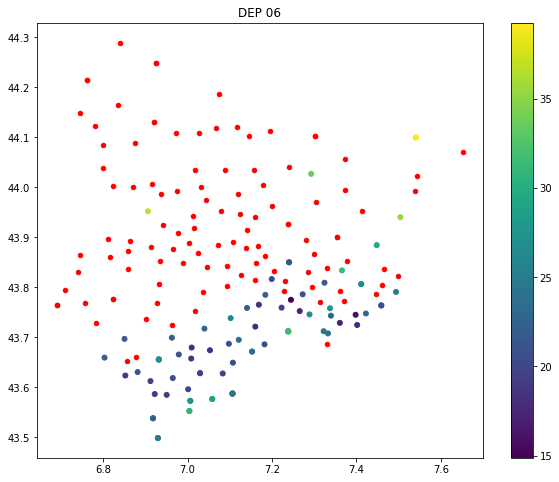

In [529]:
data = pd.merge(dep06,data_gps,on='CODE_INSEE')
data.head()
fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=25)
plt.title('DEP 06')
fig.colorbar(sc)
plt.show()

In [237]:
data.describe()

,TX_POVERTY,latitude,longitude
count,82.000000,192.000000,192.000000
mean,24.237597,43.834398,7.106258
std,5.340479,0.171841,0.210946
min,14.879468,43.498535,6.690433
25%,20.526201,43.711999,6.931905
50%,22.968498,43.811115,7.099840
75%,26.853257,43.948743,7.249955
max,39.257504,44.289466,7.651478


In [192]:
for i,c in enumerate(list_files):
    if '29' in c:
        print(i)

70


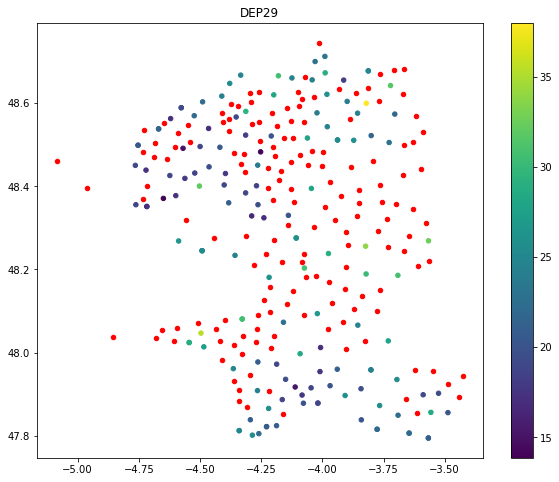

In [232]:
data = pd.merge(get_data(list_files[70]),data_gps,on='CODE_INSEE')

fig, ax = plt.subplots(figsize = (10,8))
index = data.TX_POVERTY.isna()
ax.scatter(data.longitude[index], data.latitude[index], c='r', s=20)
sc = ax.scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20)
plt.title('DEP29')
fig.colorbar(sc)
plt.show()

In [233]:
data.describe()

,TX_POVERTY,latitude,longitude
count,136.000000,295.000000,295.000000
mean,22.964588,48.286329,-4.136713
std,4.591941,0.266878,0.330245
min,13.868036,47.794341,-5.085345
25%,19.281160,48.040830,-4.354847
50%,22.217462,48.349531,-4.145808
75%,25.519968,48.513327,-3.885005
max,37.978690,48.745379,-3.426525


In [196]:
data_gps.loc[data_gps['code_INSEE'] == '75010']

,code_INSEE,latitude,longitude


# Create big csv 

In [530]:
dataframe_total = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] ".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    dataframe_total = pd.concat([dataframe_total,df])


In [531]:
dataframe_total.head()

revenu_fiscal_ref,CODE_INSEE,TX_POVERTY
0,2A001,17.815483
1,2A004,27.441333
2,2A006,17.826087
3,2A008,NaN
4,2A011,NaN


In [532]:
dataframe_total.isna().sum()

revenu_fiscal_ref
CODE_INSEE        0
TX_POVERTY    29642
dtype: int64

In [17]:
#dataframe_total.to_csv('../data/taux_pauvrete.csv',index=False)

Two approaches to complete the data.
1. mean
2. clustering

In [446]:
list_files[15]

'../../Donnees_indices_fragilites_numeriques/1 - Accès aux interfaces numériques/1 - Taux de pauvreté/2019/470.xls'

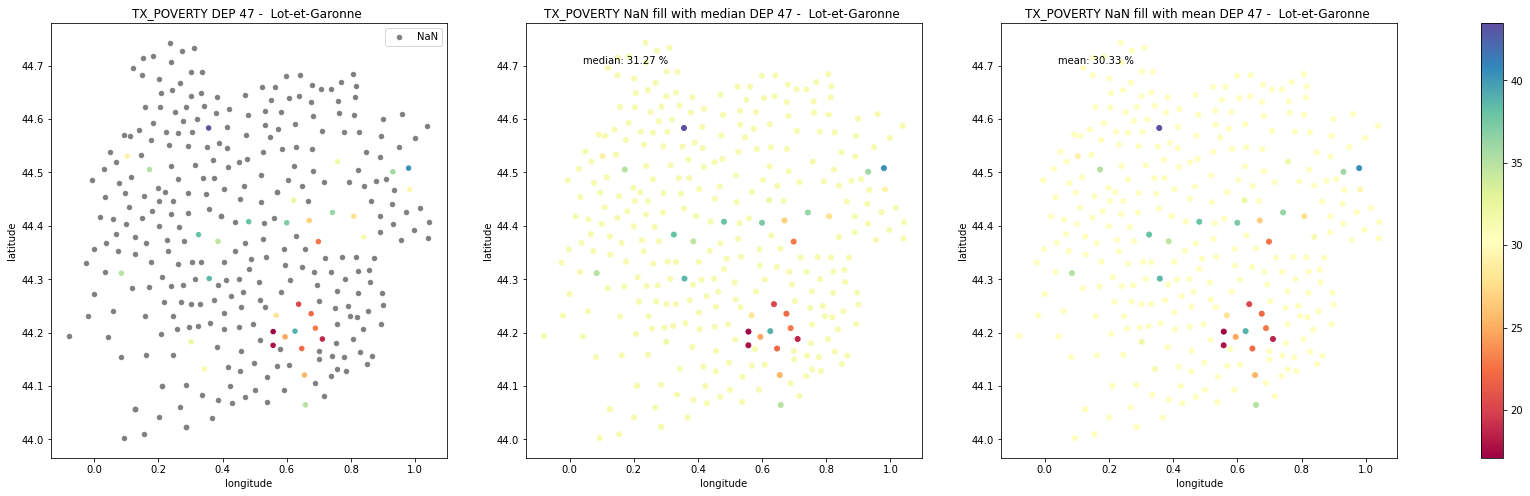

In [536]:
data = pd.merge(get_data(list_files[15]),data_gps,on='CODE_INSEE')
data_fill_median = data.fillna(value=data.TX_POVERTY.median())
data_fill_mean =  data.fillna(value=data.TX_POVERTY.mean())

fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY DEP 47 -  Lot-et-Garonne ")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median DEP 47 -  Lot-et-Garonne ')
ax[1].text(data.longitude.max()-1,data.latitude.max()-0.04,'median: {:.2F} %'.format(data.TX_POVERTY.median()))
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=data_fill_mean.TX_POVERTY, s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean DEP 47 -  Lot-et-Garonne ')
ax[2].text(data.longitude.max()-1,data.latitude.max()-0.04,'mean: {:.2F} %'.format(data.TX_POVERTY.mean()))

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())
for i in ax:
    
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
plt.show()

## Nan to median by department

In [537]:
dataframe_total_median = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    #print("[[[{}]]] nan median".format(file.split('-')[-1]))
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_median = df.fillna(value=df.TX_POVERTY.median())
    dataframe_total_median = pd.concat([dataframe_total_median,df_median])


In [538]:
dataframe_total_mean = pd.DataFrame(columns=['CODE_INSEE','TX_POVERTY'])
for file in list_files:
    # create dataset by departement and concatenate
    df = get_data(file)
    # add median
    df_mean = df.fillna(value=df.TX_POVERTY.mean())
    dataframe_total_mean = pd.concat([dataframe_total_mean,df_mean])


# Data viz

In [539]:
data = pd.merge(dataframe_total,data_gps,on='CODE_INSEE')
data_fill_median = pd.merge(dataframe_total_median,data_gps,on='CODE_INSEE')
data_fill_mean = pd.merge(dataframe_total_mean,data_gps,on='CODE_INSEE')

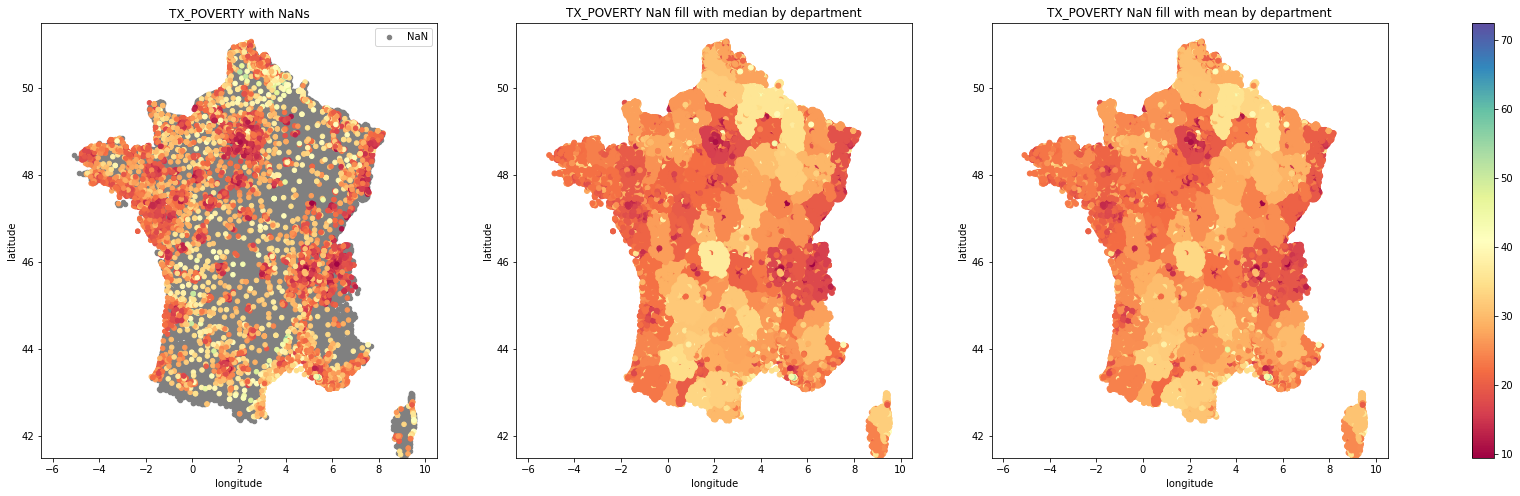

In [540]:
fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY with NaNs")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=data_fill_mean.TX_POVERTY, s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean by department')

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('tx_poverty.png', bbox_inches='tight')
plt.show()

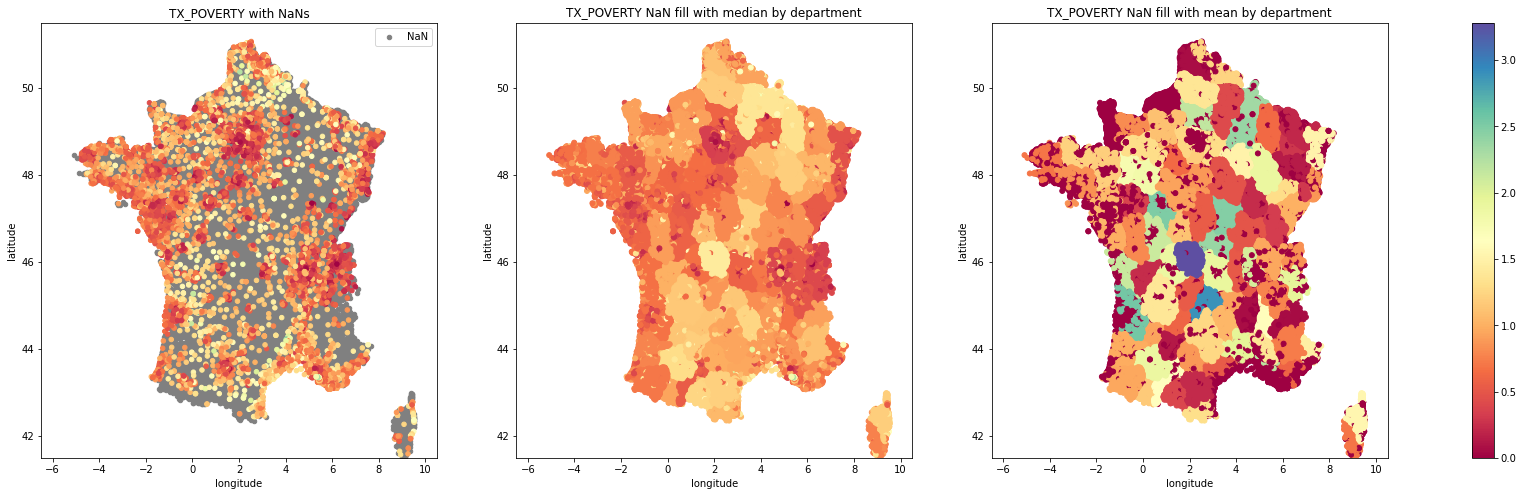

In [541]:
fig, ax = plt.subplots(1,3,figsize = (28,8))
index = data.TX_POVERTY.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_POVERTY[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_POVERTY with NaNs")
ax[0].legend()
sc = ax[1].scatter(data_fill_median.longitude,data_fill_median.latitude, c=data_fill_median.TX_POVERTY, s=25,cmap='Spectral')
ax[1].set_title('TX_POVERTY NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

sc = ax[2].scatter(data_fill_mean.longitude,data_fill_mean.latitude, c=np.abs(data_fill_median.TX_POVERTY-data_fill_mean.TX_POVERTY), s=25,cmap='Spectral')
ax[2].set_title('TX_POVERTY NaN fill with mean by department')

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
plt.savefig('tx_poverty.png', bbox_inches='tight')
plt.show()

In [542]:
print(dataframe_total_median.tail())
print(dataframe_total_mean.tail())

revenu_fiscal_ref CODE_INSEE  TX_POVERTY
421                    52546   32.358079
422                    52547   32.358079
423                    52548   32.358079
424                    52549   32.358079
425                    52550   33.152828
revenu_fiscal_ref CODE_INSEE  TX_POVERTY
421                    52546   30.454125
422                    52547   30.454125
423                    52548   30.454125
424                    52549   30.454125
425                    52550   33.152828


# export TX_POVERTY

In [543]:
dataframe_total_median.to_csv('../data/taux_pauvrete.csv',index=False)

# revision  demandeurs

In merge_v2 only 72 valeurs of tx_demandeurs appears. Problem in merge

same notebook cecile

In [563]:
demandeur_emplois = pd.read_csv('../data/raw/data_DEFM2019_com.csv', sep=";")
pop_active = pd.read_csv('../data/raw/base-cc-emploi-pop-active-2016_SHORT.csv')
pop_active2 = pd.read_csv('../data/raw/base-cc-emploi-pop-active-2016-COM.CSV', sep=";")
pop_active2 = pop_active2[['CODGEO', 'P16_ACT1564']]
pop_active = pop_active.append(pop_active2)
pop_active['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in pop_active['CODGEO']]
pop_active.head()

,CODGEO,P16_ACT1564
0,01001,376.000000
1,01002,123.000000
2,01004,6697.333122
3,01005,864.845592
4,01006,58.000000


In [564]:
pop_active.count()

CODGEO         35002
P16_ACT1564    35002
dtype: int64

In [580]:
demandeur_emplois['ABC_TOT'] = demandeur_emplois['ABC_25'] + demandeur_emplois['ABC_2649'] + demandeur_emplois['ABC_50']
demandeur_emplois['CODGEO'] = ['0'+str(X) if len(str(X)) < 5 else X for X in demandeur_emplois['CODGEO']]


In [581]:
demandeur_emplois[['CODGEO','ABC_TOT']].count()

CODGEO     1181
ABC_TOT    1180
dtype: int64

In [514]:
demandeur_emplois[['CODGEO','ABC_TOT']].isna().sum()

CODGEO     0
ABC_TOT    1
dtype: int64

In [582]:
data_emploi = pd.merge(demandeur_emplois[['CODGEO','ABC_TOT']],pop_active,on='CODGEO',how='outer')
### calculate TX_DEMANDEURS
data_emploi['TX_DEMANDEUR_EMPLOIS'] = (data_emploi['ABC_TOT'] / data_emploi['P16_ACT1564'])*100
data_emploi.columns = ['CODE_INSEE','ABC_TOT','P16_ACT1564','TX_DEMANDEUR_EMPLOIS']
print(data_emploi.head(),data_emploi.count())

  CODE_INSEE  ABC_TOT   P16_ACT1564  TX_DEMANDEUR_EMPLOIS
0      01004   1457.0   6697.333122             21.754928
1      01031    375.0   1646.324569             22.778012
2      01033   1470.0   8072.414366             18.210165
3      01034    784.0   3998.000000             19.609805
4      01053   4148.0  17702.022560             23.432351 CODE_INSEE              35002
ABC_TOT                  1180
P16_ACT1564             35002
TX_DEMANDEUR_EMPLOIS     1180
dtype: int64


In [583]:
data_emploi_gps = pd.merge(data_emploi[['CODE_INSEE','TX_DEMANDEUR_EMPLOIS']],data_gps,on='CODE_INSEE')
data_emploi_gps.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,01004,21.754928,45.960848,5.372926
1,01031,22.778012,46.237350,5.636005
2,01033,18.210165,46.106790,5.832027
3,01034,19.609805,45.749470,5.684124
4,01053,23.432351,46.205152,5.246021


In [560]:
data_emploi.count()

CODE_INSEE              35006
ABC_TOT                  1180
P16_ACT1564             35006
TX_DEMANDEUR_EMPLOIS     1180
dtype: int64

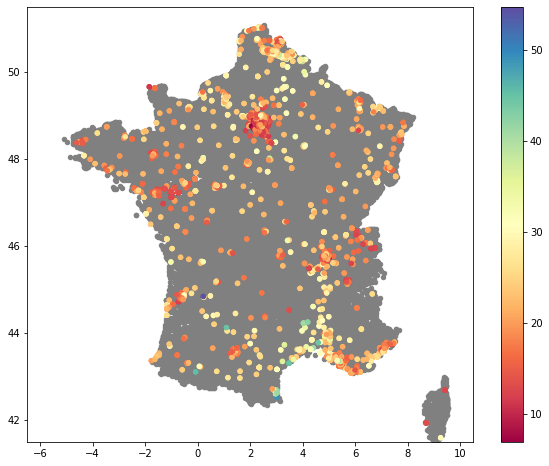

## median by department

In [589]:
dataframe_demandeurs = data_emploi.loc[:,['CODE_INSEE','TX_DEMANDEUR_EMPLOIS']]
dataframe_demandeurs['DEP'] = [str(X)[:2] for X in dataframe_demandeurs['CODE_INSEE']]
dataframe_demandeurs.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,DEP
0,01004,21.754928,01
1,01031,22.778012,01
2,01033,18.210165,01
3,01034,19.609805,01
4,01053,23.432351,01


In [591]:
TX_DEM_MEDIAN = dataframe_demandeurs.groupby(['DEP']).median().reset_index()
TX_DEM_MEDIAN.head()

,DEP,TX_DEMANDEUR_EMPLOIS
0,01,18.909985
1,02,31.534942
2,03,23.862511
3,04,27.586379
4,05,21.749293


# fill NaN demandeurs

In [613]:
dataframe_total_demandeurs = pd.DataFrame(columns=['CODE_INSEE','TX_DEMANDEUR_EMPLOIS'])

for dep,median in zip(TX_DEM_MEDIAN.DEP,TX_DEM_MEDIAN.TX_DEMANDEUR_EMPLOIS):
    df = dataframe_demandeurs.loc[dataframe_demandeurs.DEP == dep,['CODE_INSEE','TX_DEMANDEUR_EMPLOIS']].fillna(value=median)
    dataframe_total_demandeurs = pd.concat([dataframe_total_demandeurs,df])

In [614]:
dataframe_total_demandeurs.isna().sum()

CODE_INSEE              0
TX_DEMANDEUR_EMPLOIS    0
dtype: int64

In [615]:
demandeurs_fill_median = pd.merge(dataframe_total_demandeurs,data_gps,on='CODE_INSEE')
demandeurs_fill_median.head()

,CODE_INSEE,TX_DEMANDEUR_EMPLOIS,latitude,longitude
0,01004,21.754928,45.960848,5.372926
1,01031,22.778012,46.237350,5.636005
2,01033,18.210165,46.106790,5.832027
3,01034,19.609805,45.749470,5.684124
4,01053,23.432351,46.205152,5.246021


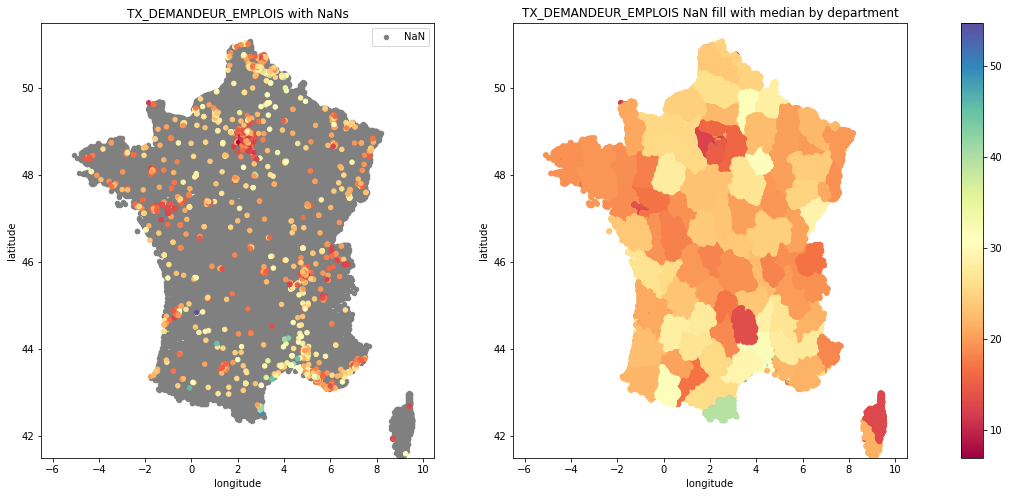

In [619]:
fig, ax = plt.subplots(1,2,figsize = (18,8))

data = data_emploi_gps
index = data.TX_DEMANDEUR_EMPLOIS.isna()
ax[0].scatter(data.longitude[index], data.latitude[index], c='gray', s=20,label="NaN")
sc = ax[0].scatter(data.longitude[-index], data.latitude[-index], c=data.TX_DEMANDEUR_EMPLOIS[-index], s=20,cmap='Spectral')
#fig.colorbar(sc,ax=ax[0])
ax[0].set_title("TX_DEMANDEUR_EMPLOIS with NaNs")
ax[0].legend()
sc = ax[1].scatter(demandeurs_fill_median.longitude,demandeurs_fill_median.latitude, c=demandeurs_fill_median.TX_DEMANDEUR_EMPLOIS, s=25,cmap='Spectral')
ax[1].set_title('TX_DEMANDEUR_EMPLOIS NaN fill with median by department')
#fig.colorbar(sc,ax=ax[1])

fig.subplots_adjust(right=0.96)
fig.colorbar(sc, ax=ax.ravel().tolist())

for i in ax:
    i.set_xlim(-6.5, 10.5)
    i.set_ylim(41.5, 51.5)
    i.set_xlabel('longitude')
    i.set_ylabel('latitude')
#plt.savefig('TX_DEMANDEUR_EMPLOIS.png', bbox_inches='tight')
plt.show()

In [622]:
dataframe_total_demandeurs.to_csv('../data/taux_demandeurs_emploi.csv',index=False)

# Edite merge and mergev2

In [3]:
# Edite merge and mergev2
merge1 = pd.read_csv('../data/processed/data_merge.csv')
merge2 = pd.read_csv('../data/processed/data_merge_V2.csv')
tx_poverty = pd.read_csv('../data/taux_pauvrete.csv')
tx_demande = pd.read_csv('../data/taux_demandeurs_emploi.csv')

merge1.drop(['TX_POVERTY','TX_DEMANDEUR_EMPLOIS'],axis=1,inplace=True)
merge1.head()

merge2.drop(['TX_POVERTY','TX_DEMANDEUR_EMPLOIS'],axis=1,inplace=True)
merge2.head()

,Unnamed: 0,CODE_INSEE,DEP,LIBCOM,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_HD_THD,TX_BENEF_MINIMAS_SOC
0,0,01001,01,L'Abergement-Clémenciat,52.154281,22.823614,4.831504,23.779236,11.309305,1.0,1
1,1,01002,01,L'Abergement-de-Varey,40.425532,28.571429,4.761905,23.404255,7.978723,1.0,1
2,2,01004,01,Ambérieu-en-Bugey,49.474587,41.515231,10.216084,20.733915,16.620013,1.0,1
3,3,01005,01,Ambérieux-en-Dombes,53.574678,21.076206,6.601983,19.488442,13.854125,1.0,1
4,4,01006,01,Ambléon,53.061224,36.363636,9.090909,26.530612,10.204082,1.0,1


In [4]:
merge1 = pd.merge(merge1,tx_demande,on='CODE_INSEE')
merge1 = pd.merge(merge1,tx_poverty,on='CODE_INSEE')
merge1.head()

,Unnamed: 0,CODE_INSEE,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_HD_THD,TX_DEMANDEUR_EMPLOIS,TX_POVERTY
0,0,2A001,47.724584,22.350501,9.322385,21.662567,10.902031,1.0,21.629062,17.815483
1,1,2A004,47.006382,26.648289,14.049949,26.619498,11.425760,1.0,13.062663,27.441333
2,2,2A006,45.656990,20.245461,9.324807,21.224153,10.888846,1.0,21.629062,17.826087
3,3,2A008,41.227734,33.376123,9.627728,36.385084,6.076146,1.0,21.629062,24.091305
4,4,2A011,47.727273,48.148148,3.703704,40.909091,11.363636,1.0,21.629062,24.091305


In [5]:
merge2 = pd.merge(merge2,tx_demande,on='CODE_INSEE')
merge2 = pd.merge(merge2,tx_poverty,on='CODE_INSEE')
merge2.head()

,Unnamed: 0,CODE_INSEE,DEP,LIBCOM,TX_NSCOL15P,TX_MENSEUL,TX_FAMMONO,TX_65ETPLUS,TX_25ETMOINS,COUVERTURE_HD_THD,TX_BENEF_MINIMAS_SOC,TX_DEMANDEUR_EMPLOIS,TX_POVERTY
0,0,01001,01,L'Abergement-Clémenciat,52.154281,22.823614,4.831504,23.779236,11.309305,1.0,1,18.909985,19.479505
1,1,01002,01,L'Abergement-de-Varey,40.425532,28.571429,4.761905,23.404255,7.978723,1.0,1,18.909985,19.479505
2,2,01004,01,Ambérieu-en-Bugey,49.474587,41.515231,10.216084,20.733915,16.620013,1.0,1,21.754928,26.170897
3,3,01005,01,Ambérieux-en-Dombes,53.574678,21.076206,6.601983,19.488442,13.854125,1.0,1,18.909985,19.479505
4,4,01006,01,Ambléon,53.061224,36.363636,9.090909,26.530612,10.204082,1.0,1,18.909985,19.479505


In [7]:
merge2.to_csv('../data/processed/data_merge_V2_FIX.csv',index=False)
merge1.to_csv('../data/processed/data_merge_V1_FIX.csv',index=False)